In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/github_projects/protein_structure_prediction

/content/drive/MyDrive/github_projects


In [5]:
# % cd ./protein_structure_prediction

In [6]:
!pwd

/content/drive/My Drive/github_projects/protein_structure_prediction


## __proteinSSpredictor__

This projects constitutes a final project for Data Science Bootcamp organised by Sages and aims at providing a deep-learning-based approach to predict secondary structure of the protein based on its primary sequence of the amino acids.

## __Table of contents__
1. Abstract
2. Source of raw sequences
3. Curation of the dataset
4. Prerequisites
5. Raw data processing
6. Exploration of preprocessed dataset for modeling
7. Sequences representation for modeling
8. Building a model
9. Where is the model making errors?
10. Summary
11. References

## __1. Abstract__

to do
-write the need for the prediction methods as the grow of the sequences amount is much higher compared to grow of the amount of structures due to time and cost

## __2. Source of raw sequences__

Preparation of the updated dataset analogous to https://www.kaggle.com/alfrandom/protein-secondary-structure

Following steps from https://github.com/zyxue/pdb-secondary-structure the secondary structure data was downloaded by

`DATE_STAMP=$(date  +'%Y-%m-%d')
wget https://cdn.rcsb.org/etl/kabschSander/ss.txt.gz -O ${DATE_TAMP}-ss.txt.gz`

Further, data was transformed to csv file analogously to https://github.com/zyxue/pdb-secondary-structure using self-implemented method (see below for more details).

## __3. Curation of the sequence dataset__ 

Further, recent PISCES data with removed peptides with high sequence similarity was downloaded from http://dunbrack.fccc.edu/Guoli/pisces_download.php

Selected precompiled CulledPDB for further modeling was generated with following criteria:

- percentage identity cutoff: 30%
- the resolution cutoff:      2.0 Å
- the R-factor cutoff:        0.25
- date of generation:         2021/07/02
- the number of sequences:    10870


## __4. Prerequisites__

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


## __5. Raw data processing__
At this point the raw sequences were converted to CSV file, translated to 3 letters representation, and combined with culledPDB list with reduced sequence identity to improve the model quality

In [8]:
from tools import process_raw_data

In [9]:
processing = process_raw_data.Sequences()

In [10]:
# %time sequences_df = processing.process_raw_sequences('../data/2021-07-09-ss.txt.gz')

In [11]:
#optional for faster processing:
sequences_df = pd.read_csv('../data/2021-07-09-ss.csv')

The set of raw sequences before processing with CulledPDB dataset contains 477154 and includes information about the sequence PDB ID code, protein chain and its primary sequence together with the secondary structure sequence

In [12]:
sequences_df.shape

(477154, 4)

In [13]:
sequences_df.head()

,pdb_id,chain,sequence,secondary_struct
0,101M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,CCCCHHHHHHHHHHHHHHGGGHHHHHHHHHHHHHHHCGGGGGGCTT...
1,102L,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...,CCHHHHHHHHHCCEEEEEECTTSCEEEETTEEEESSSCTTTHHHHH...
2,102M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,CCCCHHHHHHHHHHHHHHGGGHHHHHHHHHHHHHHHCGGGGGGCTT...
3,103L,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...,CCHHHHHHHHHCCEEEEEECTTSCEEEETTEECCCCCCCCCHHHHH...
4,103M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,CCCCHHHHHHHHHHHHHHGGGHHHHHHHHHHHHHHHCGGGGGGCTT...


In [14]:
pisces_df = processing.clean_pisces(pisces_file='../data/cullpdb_pc30_res2.0_R0.25_d2021_07_02_chains10870.gz')

In [15]:
pisces_df.head()

,length,source,resolution,R_value,R_free,pdb_id,chain
0,108,XRAY,2.0,0.21,0.25,1A1X,A
1,148,XRAY,1.8,0.19,0.24,1A3A,A
2,163,XRAY,1.8,0.21,0.30,1A73,A
3,226,XRAY,1.9,0.19,0.22,1A8L,A
4,1073,XRAY,1.8,0.19,1.00,1A9X,C


The culledPDB set containts 10870 items (PDB databases records filtered by the resolution, R-value and the 30% sequence identity). It contains information about protein PDB ID code, protein chain, method used for its determination, R-value, R-value free and the length of the sequence.

In [16]:
pisces_df.shape

(10870, 7)

In [17]:
combined_df = processing.combine_pdb_pisces(sequences_df=sequences_df, pisces_df=pisces_df)

In [18]:
combined_df.head()

,pdb_id,chain,sequence,secondary_struct,length,source,resolution,R_value,R_free
0,1A1X,A,GSAGEDVGAPPDHLWVHQEGIYRDEYQRTWVAVVEEETSFLRARVQ...,CCCCCCCCCCCSEEEEEETTEEEETTSCEEEEEEEECSSCEEEEEE...,108,XRAY,2.0,0.21,0.25
1,1A3A,A,MANLFKLGAENIFLGRKAATKEEAIRFAGEQLVKGGYVEPEYVQAM...,CCCCCCCCGGGEECSCCCSSHHHHHHHHHHHHHHTTSBCTHHHHHH...,148,XRAY,1.8,0.19,0.24
2,1A73,A,MALTNAQILAVIDSWEETVGQFPVITHHVPLGGGLQGTLHCYEIPL...,CCCCHHHHHHHHHHHHHHHTTSCEEEEEEEEETTEEEEEEEEBCCS...,163,XRAY,1.8,0.21,0.30
3,1A8L,A,MGLISDADKKVIKEEFFSKMVNPVKLIVFVRKDHCQYCDQLKQLVQ...,CCSSCHHHHHHHHHHTGGGCCSCEEEEEEECSSSCTTHHHHHHHHH...,226,XRAY,1.9,0.19,0.22
4,1A9X,F,IKSALLVLEDGTQFHGRAIGATGSAVGEVVFNTSMTGYQEILTDPS...,CCEEEEEETTCCEEEEEECSCSEEEEEEEEEECCSSCHHHHHTCGG...,379,XRAY,1.8,0.19,1.00


In [19]:
combined_df.shape

(10186, 9)

While intersecting raw sequences and culledPDB dataset by protein PDB ID codes and chains, we obtain slightly smaller set (10186) in then the original culledPDB (10870) due to some mismatches in the chain IDs

In [20]:
print(sorted(pisces_df.chain.unique()))
print(f'amount of unique chain IDs in PISCES dataset: {len(pisces_df.chain.unique())}')

['1', '2', '3', '4', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
amount of unique chain IDs in PISCES dataset: 30


In [21]:
print(sorted(sequences_df.chain.unique()))
print(f'amount of unique chain IDs in dataset of raw sequences: {len(sequences_df.chain.unique())}')

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
amount of unique chain IDs in dataset of raw sequences: 36


As the protein secondary structure can be represented in the extended form containing 8 secondary structure types (Q8) and simplified, containing only 3 secondary structure types (Q3), we create new column with the simplified version for modeling

Q8: Q3

__helices__ G, H, I: H

__sheet__ B, E: E

__coil__ T, S, C: C

Additionally, we get rid of the remaining columns and keep just PDB ID code, sequence, extended (Q8) secondary structure representation and simplified (Q3) representation as pdb_id, seq, sst_q8 and sst_q3, respectively:

In [22]:
processes_sequeces = processing.generate_seq_q8_q3_representation(combined_df)

In [23]:
processes_sequeces

,pdb_id,seq,sst_q8,sst_q3
0,1A1X,GSAGEDVGAPPDHLWVHQEGIYRDEYQRTWVAVVEEETSFLRARVQ...,CCCCCCCCCCCSEEEEEETTEEEETTSCEEEEEEEECSSCEEEEEE...,CCCCCCCCCCCCEEEEEECCEEEECCCCEEEEEEEECCCCEEEEEE...
1,1A3A,MANLFKLGAENIFLGRKAATKEEAIRFAGEQLVKGGYVEPEYVQAM...,CCCCCCCCGGGEECSCCCSSHHHHHHHHHHHHHHTTSBCTHHHHHH...,CCCCCCCCHHHEECCCCCCCHHHHHHHHHHHHHHCCCECCHHHHHH...
2,1A73,MALTNAQILAVIDSWEETVGQFPVITHHVPLGGGLQGTLHCYEIPL...,CCCCHHHHHHHHHHHHHHHTTSCEEEEEEEEETTEEEEEEEEBCCS...,CCCCHHHHHHHHHHHHHHHCCCCEEEEEEEEECCEEEEEEEEECCC...
3,1A8L,MGLISDADKKVIKEEFFSKMVNPVKLIVFVRKDHCQYCDQLKQLVQ...,CCSSCHHHHHHHHHHTGGGCCSCEEEEEEECSSSCTTHHHHHHHHH...,CCCCCHHHHHHHHHHCHHHCCCCEEEEEEECCCCCCCHHHHHHHHH...
4,1A9X,IKSALLVLEDGTQFHGRAIGATGSAVGEVVFNTSMTGYQEILTDPS...,CCEEEEEETTCCEEEEEECSCSEEEEEEEEEECCSSCHHHHHTCGG...,CCEEEEEECCCCEEEEEECCCCEEEEEEEEEECCCCCHHHHHCCHH...
...,...,...,...,...
10181,7BU2,MSMIKSYAAKEAGGELEVYEYDPGELRPQDVEVQVDYCGICHSDLS...,CCCEEEEEESSTTCCEEEEEECCCSCCTTEEEEEEEEEEECHHHHH...,CCCEEEEEECCCCCCEEEEEECCCCCCCCEEEEEEEEEEECHHHHH...
10182,7BVD,MQTTANHSSRSTQTGTRAHGAALAETTSREDFRALATEHRVVPVIR...,CCCCCCCCCCCCCCCCCCCCCCTTCCCCHHHHHHHHTTCSEEEEEE...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCHHHHHHHHCCCCEEEEEE...
10183,7BYW,MRGSHHHHHHSGQRMGMVIGIKPEHIDEYKRLHAAVWPAVLARLAE...,CCCCCCCCCCCCCEEEEEEEECGGGHHHHHHHHTTCCHHHHHHHHH...,CCCCCCCCCCCCCEEEEEEEECHHHHHHHHHHHCCCCHHHHHHHHH...
10184,7ODC,MSSFTKDEFDCHILDEGFTAKDILDQKINEVSSSDDKDAFYVADLG...,CCEEEETTEEEEEECSSCCHHHHHHHHHCCCCCCCCCCCEEEEEHH...,CCEEEECCEEEEEECCCCCHHHHHHHHHCCCCCCCCCCCEEEEEHH...


Now, I am checking whether all representations of each protein in my dataset have complementary length

In [24]:
test_df = pd.DataFrame()
test_df['seq_len'] = [len(x) for x in processes_sequeces.seq]
test_df['sst_q8_len'] = [len(x) for x in processes_sequeces.sst_q8]
test_df['sst_q3_len'] = [len(x) for x in processes_sequeces.sst_q3]

In [25]:
processes_sequeces['pdb_id'][(test_df.seq_len != test_df.sst_q8_len) | (test_df.seq_len != test_df.sst_q3_len)]

Series([], Name: pdb_id, dtype: object)

In [26]:
processes_sequeces = processes_sequeces.assign(length=test_df.seq_len)

There are no mismatches between representations, hence I proceed further. Sequences can potentially contain non-standard amino acids (https://www.samformat.info/IUPAC-ambiguity-codes).

Standard set includes 20 types: 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'

Non-standard amino acids may include: 'B', 'J', 'O', 'U', 'Z' and 'X', where the last represents unspecified or unknown (potentially missing type). Let's have a look on those.

In [27]:
nonstandard_aa = 'BJOUZX'
contains_nonstandard_aa = []
nonstandard_types = []
for sequence in processes_sequeces.seq:
    i = 0
    ns_types = ''
    for letter in sequence:
        if letter in nonstandard_aa:
            i += 1
            ns_types += letter
    contains_nonstandard_aa.append(i)
    nonstandard_types.append(ns_types)
processes_sequeces = processes_sequeces.assign(contains_nonstandard_aa = contains_nonstandard_aa)
processes_sequeces = processes_sequeces.assign(nonstandard_types = nonstandard_types)

In [28]:
processes_sequeces[processes_sequeces.contains_nonstandard_aa > 0].shape

(71, 7)

We can observe, that 71 sequences contain nonstandard amino amids, I will have a closer look at those which have more of them, focusing especially on the unknown (X) 

In [29]:
processes_sequeces[processes_sequeces.contains_nonstandard_aa > 1]

,pdb_id,seq,sst_q8,sst_q3,length,contains_nonstandard_aa,nonstandard_types
906,1SN9,XYRIPSYDFADELAKLLRQAAGX,CCEETTEEHHHHHHHHHHHHTCC,CCEECCEEHHHHHHHHHHHHCCC,23,2,XX
2135,2O5G,XARRKWQKTGHAVRAIGRLSX,CCHHHHHHHHHHHHHHHHHCC,CCHHHHHHHHHHHHHHHHHCC,21,2,XX
2140,2O6N,XAEIEQAKKEIAYLIKKAKEEILEEIKKAKQEIAX,CCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCC,CCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCC,35,2,XX
2516,2RKZ,XETLTGQYDKNLVTTVEEEYDSX,CCCEEECSCTTSCCEEEEECCCC,CCCEEECCCCCCCCEEEEECCCC,23,2,XX
2801,2XSK,MGSSQITFNTTQQGDMYTIIPEVTLTQSULURVQILSLREGSSGQS...,CCCCEEEEEEEEETTEEEEEEEEECSSCEEEEEEEEEEEECSSCEE...,CCCCEEEEEEEEECCEEEEEEEEECCCCEEEEEEEEEEEECCCCEE...,110,2,UU
3210,3CAL,XKGIVTGAVSDHTTVEDTKX,CCCCEEECCSSCEEEECCCC,CCCCEEECCCCCEEEECCCC,20,2,XX
3213,3CAY,XAXAEAAEKAAKYAAEAAEKAAKAXAX,CCHHHHHHHHHHHHHHHHHHHHHHHCC,CCHHHHHHHHHHHHHHHHHHHHHHHCC,27,4,XXXX
4431,3O3Y,XTTWEAWDXAIAEYAXRIEXLIXAAQEQQEKNEXALXELX,CCCTTTHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHSCCC,CCCCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCCC,40,8,XXXXXXXX
4933,3U5S,SMRTQQKRDTKFREDUPPDREELGRHSWAVLHTLAAYYPDLPTPEQ...,CCCCSCGGGTCCCSSSCCCHHHHHHHHHHHHHHHHHTSCSSCCHHH...,CCCCCCHHHCCCCCCCCCCHHHHHHHHHHHHHHHHHCCCCCCCHHH...,126,6,UUUUUU
5083,3W19,XNNLLRAIEAQQHLLQLTVWGIKQLQARILAVERYLKDQX,CCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCC,CCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCC,40,2,XX


In [30]:
processes_sequeces[processes_sequeces.contains_nonstandard_aa > 4]

,pdb_id,seq,sst_q8,sst_q3,length,contains_nonstandard_aa,nonstandard_types
4431,3O3Y,XTTWEAWDXAIAEYAXRIEXLIXAAQEQQEKNEXALXELX,CCCTTTHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHSCCC,CCCCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCCC,40,8,XXXXXXXX
4933,3U5S,SMRTQQKRDTKFREDUPPDREELGRHSWAVLHTLAAYYPDLPTPEQ...,CCCCSCGGGTCCCSSSCCCHHHHHHHHHHHHHHHHHTSCSSCCHHH...,CCCCCCHHHCCCCCCCCCCHHHHHHHHHHHHHHHHHCCCCCCCHHH...,126,6,UUUUUU
7112,4Z0W,XAPAPFVPAAXAVXLAXLAALXG,CCCTTTGGGGGGGGGGGGGGGCC,CCCCCCHHHHHHHHHHHHHHHCC,23,5,XXXXX
9174,6FHN,GVVQSVNVSQAGYSSNDFKTATVTASDKLSDTSYQILQGTTVIATG...,CCEEEEECCTTCEETTSCCEEEEEESSCCSCCEEEEESSSSEEEEE...,CCEEEEECCCCCEECCCCCEEEEEECCCCCCCEEEEECCCCEEEEE...,1009,33,XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
9259,6GME,XXXXXXXXXXXXXXXXXXINFKQAEKMMETMDQGDVIIRPSSKGEN...,CCCCCCCCCCCCCEEECCCCHHHHHHHHHHSCTTCEEEEECSSCTT...,CCCCCCCCCCCCCEEECCCCHHHHHHHHHHCCCCCEEEEECCCCCC...,201,18,XXXXXXXXXXXXXXXXXX


In [31]:
processes_sequeces.seq[processes_sequeces.pdb_id == '6FHN'].values

array(['GVVQSVNVSQAGYSSNDFKTATVTASDKLSDTSYQILQGTTVIATGTMKDEGYVWGKYVYSIDFSSVTATGTNFTIRSNGVSSYTFPIQTNMWNEYKDEMTAFYRLLRTTDTFAAYPAGYSNIAPSNKILHPDSFLDDAFSPDRTTHYDLTGGWFDAGDYGKYGGNQWVQGNIAISYLRHASSAAVNFDKDTNGIPDLVDEAIFGSQYLVKFANQLGGAIHNILRKGGFVLPHKVTDNVPGNTDDRALEAVEAVGGSGKSSGSLAATARAIRTAIAGGKVAANKVAQLQTLANEFQAAAIIFYNYTLTHQSGNHGSYGTMNNGGIANPLLWAEVQLYLLTGDAAYKTQAQTRINAINEAYVSSTNYWDMHPIALAEFYPVADSAIKTKIQSILKHQAYYFITLMDETPYGVLNQFGNFGVNEPHASYMADLLRYYELFNDPVALRAAKKALYWIVGNNPWNISWVSGVGSNFTDFLHTRLDEEAYSQTNTGVVLPGAMVSGPNIKDPNNKLSSSPWYEDKPIWADDTNQWRYNEYSVSIQTGLFYTIMGLSALGGNASTGGAEPVKLPITWPIIGDYVTGDVTVFAQPEGSLSNVSANGIVLSPSDGVYTTTVSTSADAPYTERKVQIKGTDDSGFTTYSNTHFTVAPALPDPSHPLLFDDFNQKGIWGSQKLDWVNWYNQNGGTASYTRTTVDTRTVGKFAHTPAATTSKAKFQPWKYNANLNGYRYLNFTMKNPGYPNTKIRIAANDGTKSVNLTSGEVAISSTWTTYQYDLNLHPTLNKSNVLIEVWLSNPTAGAYGEILIDEISAVNTNSGTAPTLSATGVNASIGNQSTVFTYTATYTDANNQAPFDVQVVIDGVIRSMTAADPTDTTYSDGRVYTYATTLPVGTHKFYFRTTDTTTNFVSTSVQTGPTVIRNKLEAEVLSINLTNYTHAVKDNADASGGKYRLFNGRQANDYIEYAVNVPKAGTYQVSAXXXXXXXXXXXXXXXXX

In [32]:
processes_sequeces.seq[processes_sequeces.pdb_id == '6GME'].values

array(['XXXXXXXXXXXXXXXXXXINFKQAEKMMETMDQGDVIIRPSSKGENHLTVTWKVSDGIYQHVDVREEGKENAFSLGATLWINSEEFEDLDEIVARYVQPMASFARDLLNHKYYQDCSGGDRKKLEELLIKTKKEKPTFIPYFICACKELPGKFLLGYQPRGKPRIEYVTVTPEGFRYRGQIFPTVNGLFRWFKDHYQDPVP'],
      dtype=object)

There are two sequences (6FHN and 6GME) in the dataset which contains significant amount of the unknown residues at the beginning or end, which most likely is conditioned by high mobility of these regions preventing correct assignment of the amino acid type, which affects the quality of the DSSP secondary structure prediciton, so I will remove these two sequences from the dataset, as they are most likely of lower quality besides their relatively high resolution as filtered in CulledPDB from PISCES.

In [33]:
processes_sequeces = processes_sequeces.drop(processes_sequeces[processes_sequeces.contains_nonstandard_aa > 10].index)

## __6. Exploration of preprocessed dataset for modeling__

I will now have a brief look on prepared sequences, which I will later use while evaluating the model quality

In [34]:
from tools import visualizer

In [35]:
processes_sequeces.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10184 entries, 0 to 10185
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   pdb_id                   10184 non-null  object
 1   seq                      10184 non-null  object
 2   sst_q8                   10184 non-null  object
 3   sst_q3                   10184 non-null  object
 4   length                   10184 non-null  int64 
 5   contains_nonstandard_aa  10184 non-null  int64 
 6   nonstandard_types        10184 non-null  object
dtypes: int64(2), object(5)
memory usage: 636.5+ KB


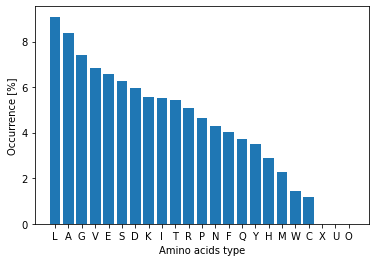

In [36]:
visualizer.visualize_occurrence(feature_series=processes_sequeces.seq, xlabel='Amino acids type').show()

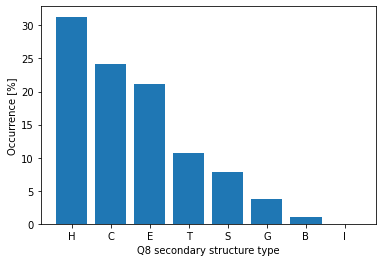

In [37]:
visualizer.visualize_occurrence(feature_series=processes_sequeces.sst_q8, xlabel='Q8 secondary structure type').show()

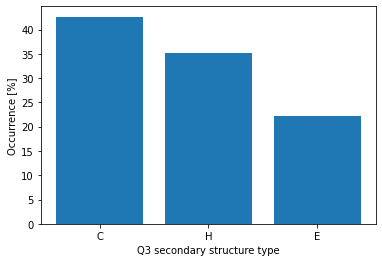

In [38]:
visualizer.visualize_occurrence(feature_series=processes_sequeces.sst_q3, xlabel='Q3 secondary structure type').show()

## __7. Sequences representation for modeling__

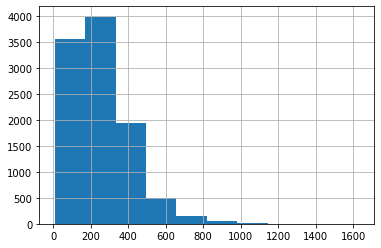

In [39]:
processes_sequeces.length.hist()
plt.show()

Most of the sequences in prepared dataset do not exceed the length of 500 amino acids, hence I will limit the max length to 500 and unify the length of the samples by padding accordingly

In [40]:
maxlen = 500

Now I will prepare sequences for modeling. As my ulimate goal is to use a so called ProtVec embedding obtained on the large dataset for DNA, RNA and Protein sequences (https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0141287), I will represent my sequences in the same form of ngrams consisting of 3 consecutive amino acids in the sequence as it was shown to represent the protein sequence well for deep learning applications (https://pubs.acs.org/doi/10.1021/acs.jcim.0c00073).  

In [41]:
from tools import prepare_for_modeling

In [42]:
input_sequences = prepare_for_modeling.convert_to_ngrams(sequences=processes_sequeces.seq, n=3)

In [43]:
X_seq, seq_index = prepare_for_modeling.tokenize_inputs(input_sequences=input_sequences, maxlen=maxlen)

In [44]:
y_sst8, sst8_index = prepare_for_modeling.tokenize_target(target_sst=processes_sequeces.sst_q8, maxlen=maxlen)

In [45]:
y_sst3, sst3_index = prepare_for_modeling.tokenize_target(target_sst=processes_sequeces.sst_q3, maxlen=maxlen)

In [46]:
X_seq.shape, y_sst8.shape, y_sst3.shape

((10184, 500), (10184, 500, 9), (10184, 500, 4))

3 state prediction dataset split 

In [47]:
X_train, X_test, y_train_q3, y_test_q3 = train_test_split(X_seq, y_sst3, test_size=0.2, random_state=42)

In [48]:
X_train.shape, X_test.shape, y_train_q3.shape, y_test_q3.shape

((8147, 500), (2037, 500), (8147, 500, 4), (2037, 500, 4))

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, Embedding, Dense, TimeDistributed, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model

In [50]:
# batch_size = 32
embedding_dims = 500
epochs = 5

In [51]:
n_words = len(seq_index) + 1  # including the padding
n_tags = len(sst3_index) + 1  # including the padding
print(n_words, n_tags)
# old 8586 4

8586 4


In [54]:
protvec_shape, protvec_embeddings = prepare_for_modeling.parse_protvec_embeddings('../uniref_3M.vec')

In [55]:
protvec_shape

(10180, 1000)

In [56]:
len(protvec_embeddings.keys())

10180

In [133]:
embedding_matrix = np.zeros((len(seq_index) + 1, protvec_shape[1]))
for word, i in seq_index.items():
    embedding_vector = protvec_embeddings.get(word.upper())
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


In [135]:
embedding_matrix.shape

(8586, 1000)

In [ ]:
# model = Sequential()
# # model.add(InputLayer(shape=(maxlen,)))
# model.add(Embedding(input_shape=(maxlen,), input_dim=n_words, output_dim=maxlen, input_length=maxlen))
# model.add(Bidirectional(LSTM(units=64, return_sequences=True, recurrent_dropout=0.0, activation='relu')))
# model.add(Bidirectional(LSTM(units=32, return_sequences=True, recurrent_dropout=0.0, activation='relu')))
# model.add(TimeDistributed(Dense(n_tags, activation="softmax")))
# model.summary()


In [58]:
# model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
# model.fit(X_train, y_train_q3, epochs=10)
# model.evaluate(X_test,y_test_q3)
# model.save('./first_model_proteinSSpredictor_2xLSTM.h5')

In [59]:
# trained_model = load_model('../models/first_model_proteinSSpredictor_2xLSTM.h5')
# trained_model.evaluate(X_test,y_test_q3)


    Simple RNN
    LSTM - porównaj na zbiorze testowym jakość działania modelu wziętego z najlepszej iteracji oraz modelu po zatrzymaniu uczenia
    LSTM + warstwa/y dense na końcu
    BiLSTM
    dwuwarstwowy LSTM
    dwuwartwowy BiLSTM + dense
    CNN + LSTM - przepuścić dane przez warstwę konwolucyjną - conv1d (+ max pooling), a następnie przejechać LSTM'em po tym wyszło.


Wykorzystanie gotowych (pretrained) embeddingów:¶

Embedding(..., weights = [embeddings], trainable = True/False)

Parametr trainable - określa czy chcemy douczać nasze embeddingi czy nie.


In [60]:
#accuracy_score(y_test, model.predict(x_test))

Now, working on the Q3 secondary structure classification, I will test few models with various layers.

In [80]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                              patience=10,
                              restore_best_weights=True)

In [81]:
# LSTM
model1 = Sequential()
model1.add(Embedding(input_shape=(maxlen,), 
                     input_dim=n_words, 
                     output_dim=100, 
                     input_length=maxlen))
model1.add(LSTM(units=64,
                activation='tanh', 
                recurrent_activation='sigmoid', 
                return_sequences=True))
model1.add(TimeDistributed(Dense(n_tags, 
                                 activation="softmax")))
model1.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 500, 100)          858600    
_________________________________________________________________
lstm_10 (LSTM)               (None, 500, 64)           42240     
_________________________________________________________________
time_distributed_7 (TimeDist (None, 500, 4)            260       
Total params: 901,100
Trainable params: 901,100
Non-trainable params: 0
_________________________________________________________________


In [82]:
model1.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
model1_history = model1.fit(X_train,
                            y_train_q3,
                            validation_split=0.2,
                            callbacks=[early_stopping], 
                            epochs=100)
model1.save('../models/model1_lstm_x1.h5')
model1.evaluate(X_test, y_test_q3) 

Epoch 1/100
204/204 [==============================] - 8s 35ms/step - loss: 0.2378 - accuracy: 0.7430 - val_loss: 0.1875 - val_accuracy: 0.8109
Epoch 2/100
204/204 [==============================] - 7s 32ms/step - loss: 0.1861 - accuracy: 0.8141 - val_loss: 0.1826 - val_accuracy: 0.8171
Epoch 3/100
204/204 [==============================] - 7s 32ms/step - loss: 0.1796 - accuracy: 0.8224 - val_loss: 0.1790 - val_accuracy: 0.8216
Epoch 4/100
204/204 [==============================] - 7s 32ms/step - loss: 0.1746 - accuracy: 0.8290 - val_loss: 0.1800 - val_accuracy: 0.8199
Epoch 5/100
204/204 [==============================] - 7s 34ms/step - loss: 0.1707 - accuracy: 0.8341 - val_loss: 0.1790 - val_accuracy: 0.8217
Epoch 6/100
204/204 [==============================] - 7s 34ms/step - loss: 0.1677 - accuracy: 0.8377 - val_loss: 0.1795 - val_accuracy: 0.8215
Epoch 7/100
204/204 [==============================] - 7s 34ms/step - loss: 0.1643 - accuracy: 0.8419 - val_loss: 0.1816 - val_accuracy:

[0.1831052601337433, 0.8178134560585022]

In [86]:
model1_hist_df = pd.DataFrame(model1_history.history)
with open('../models/model1_lstm_x1_history.csv', 'w') as out:
  model1_hist_df.to_csv(out)

In [93]:
# 2x LSTM
model2 = Sequential()
model2.add(Embedding(input_shape=(maxlen,), 
                     input_dim=n_words, 
                     output_dim=100, 
                     input_length=maxlen))
model2.add(LSTM(units=128,
                activation='tanh', 
                recurrent_activation='sigmoid', 
                return_sequences=True))
model2.add(LSTM(units=64,
                activation='tanh', 
                recurrent_activation='sigmoid', 
                return_sequences=True))
model2.add(TimeDistributed(Dense(n_tags, 
                                 activation="softmax")))
model2.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 500, 100)          858600    
_________________________________________________________________
lstm_17 (LSTM)               (None, 500, 128)          117248    
_________________________________________________________________
lstm_18 (LSTM)               (None, 500, 64)           49408     
_________________________________________________________________
time_distributed_11 (TimeDis (None, 500, 4)            260       
Total params: 1,025,516
Trainable params: 1,025,516
Non-trainable params: 0
_________________________________________________________________


In [94]:
model2.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
model2_history = model2.fit(X_train,
                            y_train_q3,
                            validation_split=0.2,
                            callbacks=[early_stopping], 
                            epochs=100)
model2.save('../models/model2_lstm_x2.h5')
model2.evaluate(X_test, y_test_q3) 

Epoch 1/100
204/204 [==============================] - 15s 63ms/step - loss: 0.2395 - accuracy: 0.7218 - val_loss: 0.1979 - val_accuracy: 0.7939
Epoch 2/100
204/204 [==============================] - 12s 59ms/step - loss: 0.1890 - accuracy: 0.8104 - val_loss: 0.1821 - val_accuracy: 0.8181
Epoch 3/100
204/204 [==============================] - 13s 63ms/step - loss: 0.1799 - accuracy: 0.8222 - val_loss: 0.1803 - val_accuracy: 0.8195
Epoch 4/100
204/204 [==============================] - 12s 60ms/step - loss: 0.1750 - accuracy: 0.8287 - val_loss: 0.1787 - val_accuracy: 0.8221
Epoch 5/100
204/204 [==============================] - 11s 56ms/step - loss: 0.1712 - accuracy: 0.8333 - val_loss: 0.1784 - val_accuracy: 0.8225
Epoch 6/100
204/204 [==============================] - 11s 55ms/step - loss: 0.1677 - accuracy: 0.8377 - val_loss: 0.1794 - val_accuracy: 0.8218
Epoch 7/100
204/204 [==============================] - 11s 56ms/step - loss: 0.1643 - accuracy: 0.8420 - val_loss: 0.1803 - val_ac

[0.18242008984088898, 0.8188414573669434]

In [95]:
model2_hist_df = pd.DataFrame(model2_history.history)
with open('../models/model2_lstm_x2_history.csv', 'w') as out:
  model2_hist_df.to_csv(out)

In [136]:
# 2x LSTM + protvec embeddings
model3 = Sequential()
model3.add(Embedding(input_dim = len(seq_index) + 1,
                     output_dim = protvec_shape[1],
                     weights=[embedding_matrix],
                     input_length=maxlen,
                     trainable=False))
model3.add(LSTM(units=128,
                activation='tanh', 
                recurrent_activation='sigmoid', 
                return_sequences=True))
model3.add(LSTM(units=64,
                activation='tanh', 
                recurrent_activation='sigmoid', 
                return_sequences=True))
model3.add(TimeDistributed(Dense(n_tags, 
                                 activation="softmax")))
model3.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 500, 1000)         8586000   
_________________________________________________________________
lstm_23 (LSTM)               (None, 500, 128)          578048    
_________________________________________________________________
lstm_24 (LSTM)               (None, 500, 64)           49408     
_________________________________________________________________
time_distributed_14 (TimeDis (None, 500, 4)            260       
Total params: 9,213,716
Trainable params: 627,716
Non-trainable params: 8,586,000
_________________________________________________________________


In [137]:
model3.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
model3_history = model3.fit(X_train,
                            y_train_q3,
                            validation_split=0.2,
                            callbacks=[early_stopping], 
                            epochs=100)
model3.save('../models/model3_lstm_x2_protvec_embeddings.h5')
model3.evaluate(X_test, y_test_q3)

Epoch 1/100
204/204 [==============================] - 17s 72ms/step - loss: 0.2259 - accuracy: 0.7666 - val_loss: 0.1919 - val_accuracy: 0.8031
Epoch 2/100
204/204 [==============================] - 14s 68ms/step - loss: 0.1915 - accuracy: 0.8062 - val_loss: 0.1878 - val_accuracy: 0.8085
Epoch 3/100
204/204 [==============================] - 14s 69ms/step - loss: 0.1873 - accuracy: 0.8115 - val_loss: 0.1816 - val_accuracy: 0.8178
Epoch 4/100
204/204 [==============================] - 15s 73ms/step - loss: 0.1844 - accuracy: 0.8152 - val_loss: 0.1804 - val_accuracy: 0.8190
Epoch 5/100
204/204 [==============================] - 15s 71ms/step - loss: 0.1817 - accuracy: 0.8186 - val_loss: 0.1788 - val_accuracy: 0.8210
Epoch 6/100
204/204 [==============================] - 14s 70ms/step - loss: 0.1799 - accuracy: 0.8208 - val_loss: 0.1772 - val_accuracy: 0.8230
Epoch 7/100
204/204 [==============================] - 14s 68ms/step - loss: 0.1785 - accuracy: 0.8222 - val_loss: 0.1796 - val_ac

[0.1759345978498459, 0.8264064788818359]

In [138]:
model3_hist_df = pd.DataFrame(model3_history.history)
with open('../models/model3_lstm_x2_protvec_embeddings_history.csv', 'w') as out:
  model3_hist_df.to_csv(out)